In [13]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    TrainerCallback, EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [14]:
# 📂 Load and preprocess dataset
df = pd.read_csv("./dataset.csv")
df.columns = df.columns.str.strip()
df = df.iloc[1:]
df = df[df['Level'].isin([0, 1, 2, 3])]
df['Level'] = df['Level'].astype(int)
df.rename(columns={'Level': 'labels'}, inplace=True)

# 🧪 Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

In [15]:
# 📤 Convert to HF Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# 🔠 Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["Response"], truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

C:\ProgramData\anaconda3\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4112 [00:00<?, ? examples/s]

Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

In [16]:
# 📦 Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 🧠 Load DistilBERT
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# 📊 Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=-1).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
    }

In [18]:
# 🧩 Callback to track train/val accuracy
class AccuracyTrackerCallback(TrainerCallback):
    def __init__(self, trainer_ref):
        self.trainer = trainer_ref
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        train_output = self.trainer.predict(self.trainer.train_dataset)
        train_preds = train_output.predictions.argmax(axis=1)
        train_labels = train_output.label_ids
        train_acc = accuracy_score(train_labels, train_preds)
        self.train_accuracies.append(train_acc)

        eval_output = self.trainer.predict(self.trainer.eval_dataset)
        eval_preds = eval_output.predictions.argmax(axis=1)
        eval_labels = eval_output.label_ids
        eval_acc = accuracy_score(eval_labels, eval_preds)
        self.eval_accuracies.append(eval_acc)

        print(f"\n📊 Epoch {state.epoch:.0f} → Train Acc: {train_acc:.4f} | Val Acc: {eval_acc:.4f}")

In [20]:
# ⚙️ Training Arguments (Updated)
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_dir="./distilbert_logs",
    logging_steps=50,
    save_total_limit=2
)


In [21]:
# 📦 Initialize trainer
accuracy_logger = AccuracyTrackerCallback(None)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        accuracy_logger,
        EarlyStoppingCallback(early_stopping_patience=7)
    ]
)
accuracy_logger.trainer = trainer

In [22]:
# 🚀 Train
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.423200,0.411035,0.861030,0.875409,0.827238,0.836896
2,0.244200,0.306074,0.918367,0.909018,0.911745,0.909541
3,0.132500,0.359286,0.917396,0.912396,0.907937,0.908584
4,0.043200,0.349794,0.929057,0.926676,0.916775,0.920343
5,0.005600,0.397150,0.929057,0.921958,0.927091,0.923180
6,0.021600,0.389536,0.932945,0.929991,0.925680,0.927129
7,0.008700,0.367792,0.937804,0.931846,0.934014,0.932571
8,0.001200,0.413536,0.934888,0.936360,0.923687,0.928814
9,0.009800,0.375410,0.943635,0.939054,0.937567,0.938199
10,0.018200,0.404667,0.942663,0.942354,0.932872,0.936357



📊 Epoch 1 → Train Acc: 0.8949 | Val Acc: 0.8610

📊 Epoch 2 → Train Acc: 0.9769 | Val Acc: 0.9184

📊 Epoch 3 → Train Acc: 0.9929 | Val Acc: 0.9174

📊 Epoch 4 → Train Acc: 0.9973 | Val Acc: 0.9291

📊 Epoch 5 → Train Acc: 0.9988 | Val Acc: 0.9291

📊 Epoch 6 → Train Acc: 0.9993 | Val Acc: 0.9329

📊 Epoch 7 → Train Acc: 0.9988 | Val Acc: 0.9378

📊 Epoch 8 → Train Acc: 0.9993 | Val Acc: 0.9349

📊 Epoch 9 → Train Acc: 0.9998 | Val Acc: 0.9436

📊 Epoch 10 → Train Acc: 1.0000 | Val Acc: 0.9427

📊 Epoch 11 → Train Acc: 1.0000 | Val Acc: 0.9436

📊 Epoch 12 → Train Acc: 1.0000 | Val Acc: 0.9310

📊 Epoch 13 → Train Acc: 0.9998 | Val Acc: 0.9329

📊 Epoch 14 → Train Acc: 1.0000 | Val Acc: 0.9407

📊 Epoch 15 → Train Acc: 1.0000 | Val Acc: 0.9456

📊 Epoch 16 → Train Acc: 1.0000 | Val Acc: 0.9407

📊 Epoch 17 → Train Acc: 1.0000 | Val Acc: 0.9397

📊 Epoch 18 → Train Acc: 1.0000 | Val Acc: 0.9407

📊 Epoch 19 → Train Acc: 1.0000 | Val Acc: 0.9417

📊 Epoch 20 → Train Acc: 1.0000 | Val Acc: 0.9378


TrainOutput(global_step=10280, training_loss=0.05468987102640065, metrics={'train_runtime': 964.9829, 'train_samples_per_second': 85.224, 'train_steps_per_second': 10.653, 'total_flos': 545592649820736.0, 'train_loss': 0.05468987102640065, 'epoch': 20.0})

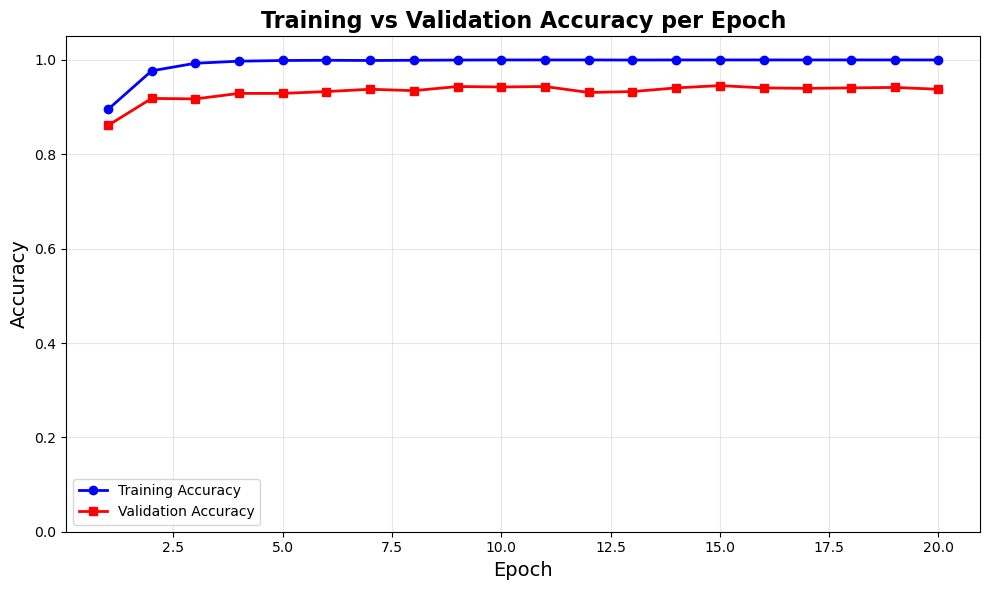

In [23]:
# 📈 Plot Training vs Validation Accuracy
train_accs = accuracy_logger.train_accuracies
val_accs = accuracy_logger.eval_accuracies
epochs = range(1, len(train_accs) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accs, label="Training Accuracy", marker='o', linewidth=2, color='blue')
plt.plot(epochs, val_accs, label="Validation Accuracy", marker='s', linewidth=2, color='red')

plt.title("Training vs Validation Accuracy per Epoch", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



🔍 Classification Report:

              precision    recall  f1-score   support

     Level 0     0.9680    0.9737    0.9708       342
     Level 1     0.9588    0.8900    0.9231       209
     Level 2     0.8768    0.9487    0.9113       195
     Level 3     0.9607    0.9505    0.9556       283

    accuracy                         0.9456      1029
   macro avg     0.9411    0.9407    0.9402      1029
weighted avg     0.9468    0.9456    0.9457      1029


📊 Final Test Accuracy: 0.9456


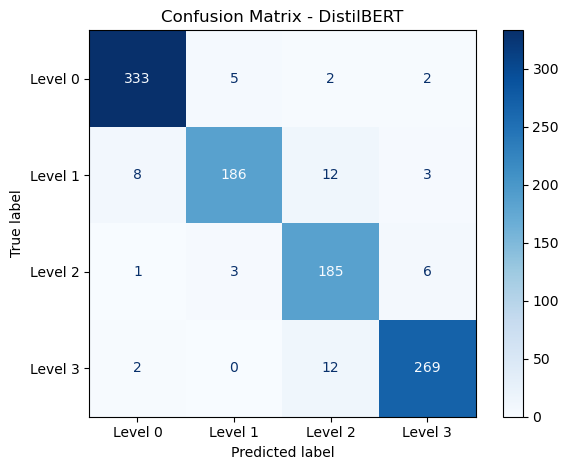

In [24]:
# 🔍 Final Evaluation
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)
y_true = preds.label_ids

print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Level 0", "Level 1", "Level 2", "Level 3"], digits=4))
print(f"\n📊 Final Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Level 0", "Level 1", "Level 2", "Level 3"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - DistilBERT")
plt.tight_layout()
plt.show()